### Load required libraries and data

In [5]:
import os
import anndata as ad
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import copy
import re
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from datetime import datetime

pwd = os.getcwd()
            
def boxplots(
        data,
        feature_name,
        y_scale="relative",
        plot_facets=False,
        add_dots=False,
        cell_types=None,
        args_boxplot={},
        args_swarmplot={},
        figsize=None,
        dpi=100,
        cmap="Blues",
        plot_legend=True,
        level_order=None):
    """
    Grouped boxplot visualization. The cell counts for each cell type are shown as a group of boxplots,
    with intra--group separation by a covariate from data.obs.
    The cell type groups can either be ordered along the x-axis of a single plot (plot_facets=False) or as plot facets (plot_facets=True).
    Parameters
    ----------
    data
        A scCODA-compatible data object
    feature_name
        The name of the feature in data.obs to plot
    y_scale
        Transformation to of cell counts. Options: "relative" - Relative abundance, "log" - log(count), "count" - absolute abundance (cell counts)
    plot_facets
        If False, plot cell types on the x-axis. If True, plot as facets
    add_dots
        If True, overlay a scatterplot with one dot for each data point
    cell_types
        Subset of cell types that should be plotted
    args_boxplot
        Arguments passed to sns.boxplot
    args_swarmplot
            Arguments passed to sns.swarmplot
    figsize
        figure size
    dpi
        dpi setting
    cmap
        The seaborn color map for the barplot
    plot_legend
        If True, adds a legend
    level_order
        Custom ordering of bars on the x-axis
    Returns
    -------
    Depending on `plot_facets`, returns a :class:`~plt.AxesSubplot` (`plot_facets = False`) or :class:`~sns.axisgrid.FacetGrid` (`plot_facets = True`) object
    ax
        if `plot_facets = False`
    g
        if `plot_facets = True`
    """

    # y scale transformations
    if y_scale == "relative":
        sample_sums = np.sum(data.X, axis=1, keepdims=True)
        X = data.X/sample_sums
        value_name = "Proportion"
    elif y_scale == "log_relative":
        sample_sums = np.sum(data.X, axis=1, keepdims=True)
        X = np.log10((data.X + 1)/(sample_sums + data.shape[1]))
        value_name = "log(Proportion)"
    # add pseudocount 1 if using log scale (needs to be improved)
    elif y_scale == "log":
        X = np.log10(data.X + 1)
        value_name = "log(count)"
    elif y_scale == "count":
        X = data.X
        value_name = "count"
    else:
        raise ValueError("Invalid y_scale transformation")

    count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
        merge(data.obs[feature_name], left_index=True, right_index=True)
    plot_df = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)
    if cell_types is not None:
        plot_df = plot_df[plot_df["Cell type"].isin(cell_types)]

    if plot_facets:

        if level_order is None:
            level_order = pd.unique(plot_df[feature_name])

        K = X.shape[1]

        g = sns.FacetGrid(
            plot_df,
            col="Cell type",
            sharey=False,
            col_wrap=np.floor(np.sqrt(K)),
            height=5,
            aspect=2,
        )
        g.map(
            sns.boxplot,
            feature_name,
            value_name,
            palette=cmap,
            order=level_order,
            **args_boxplot
        )

        if add_dots:

            if "hue" in args_swarmplot:
                hue = args_swarmplot.pop("hue")
            else:
                hue = None

            if hue is None:
                g.map(
                    sns.swarmplot,
                    feature_name,
                    value_name,
                    color="black",
                    order=level_order,
                    **args_swarmplot
                ).set_titles("{col_name}")
            else:
                g.map(
                    sns.swarmplot,
                    feature_name,
                    value_name,
                    hue,
                    order=level_order,
                    **args_swarmplot
                ).set_titles("{col_name}")

        return g

    else:

        if level_order:
            args_boxplot["hue_order"] = level_order
            args_swarmplot["hue_order"] = level_order

        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        sns.boxplot(x="Cell type", y=value_name, hue=feature_name, data=plot_df, fliersize=1,
                    palette=cmap, ax=ax, **args_boxplot)

        if add_dots:
            sns.swarmplot(
                x="Cell type",
                y=value_name,
                data=plot_df,
                hue=feature_name,
                ax=ax,
                dodge=True,
                color="black",
                **args_swarmplot
            )

        cell_types = pd.unique(plot_df["Cell type"])
        ax.set_xticklabels(cell_types, rotation=90)

        if plot_legend:
            handles, labels = ax.get_legend_handles_labels()
            handout = []
            labelout = []
            for h, l in zip(handles, labels):
                if l not in labelout:
                    labelout.append(l)
                    handout.append(h)
            ax.legend(handout, labelout, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title=feature_name)

        plt.tight_layout()

        return ax

subclass


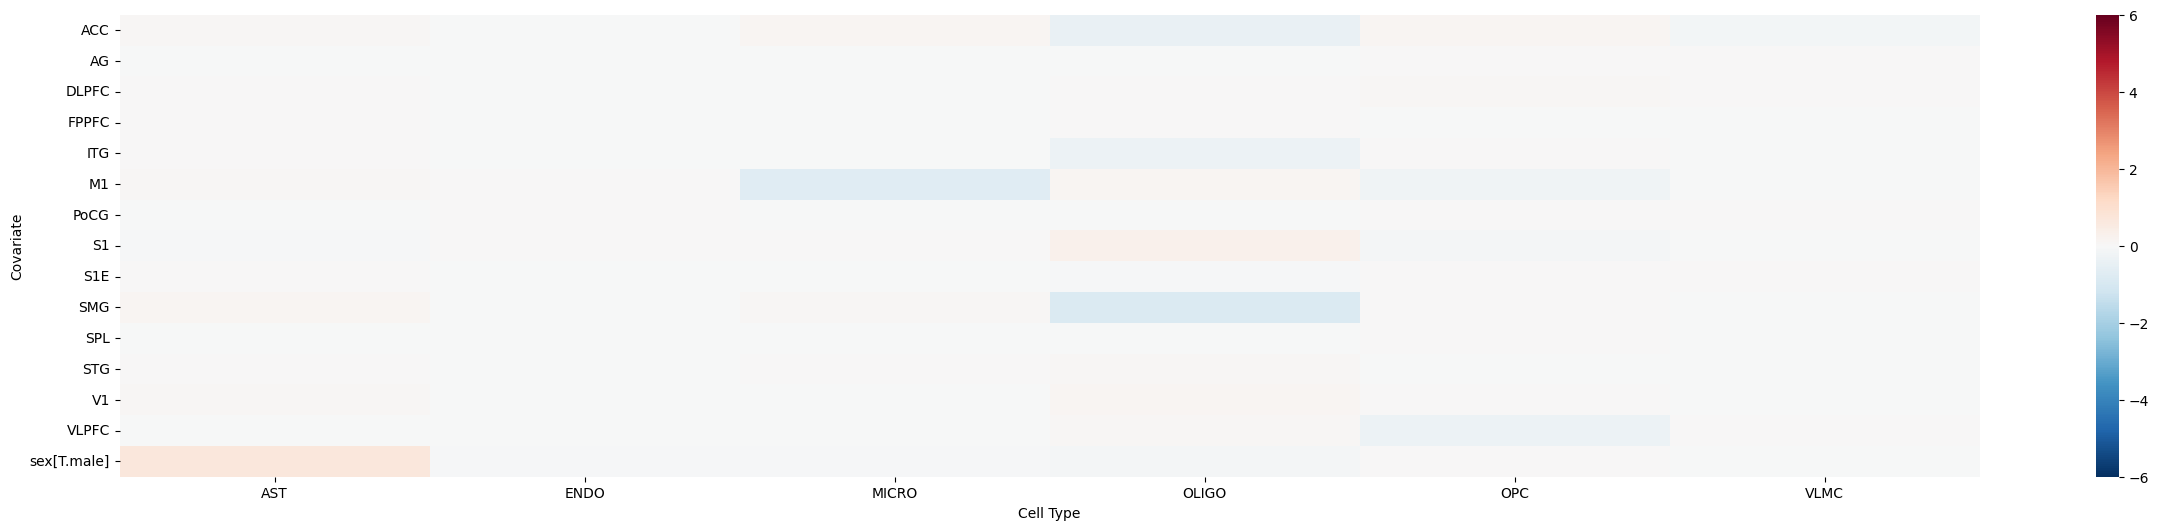

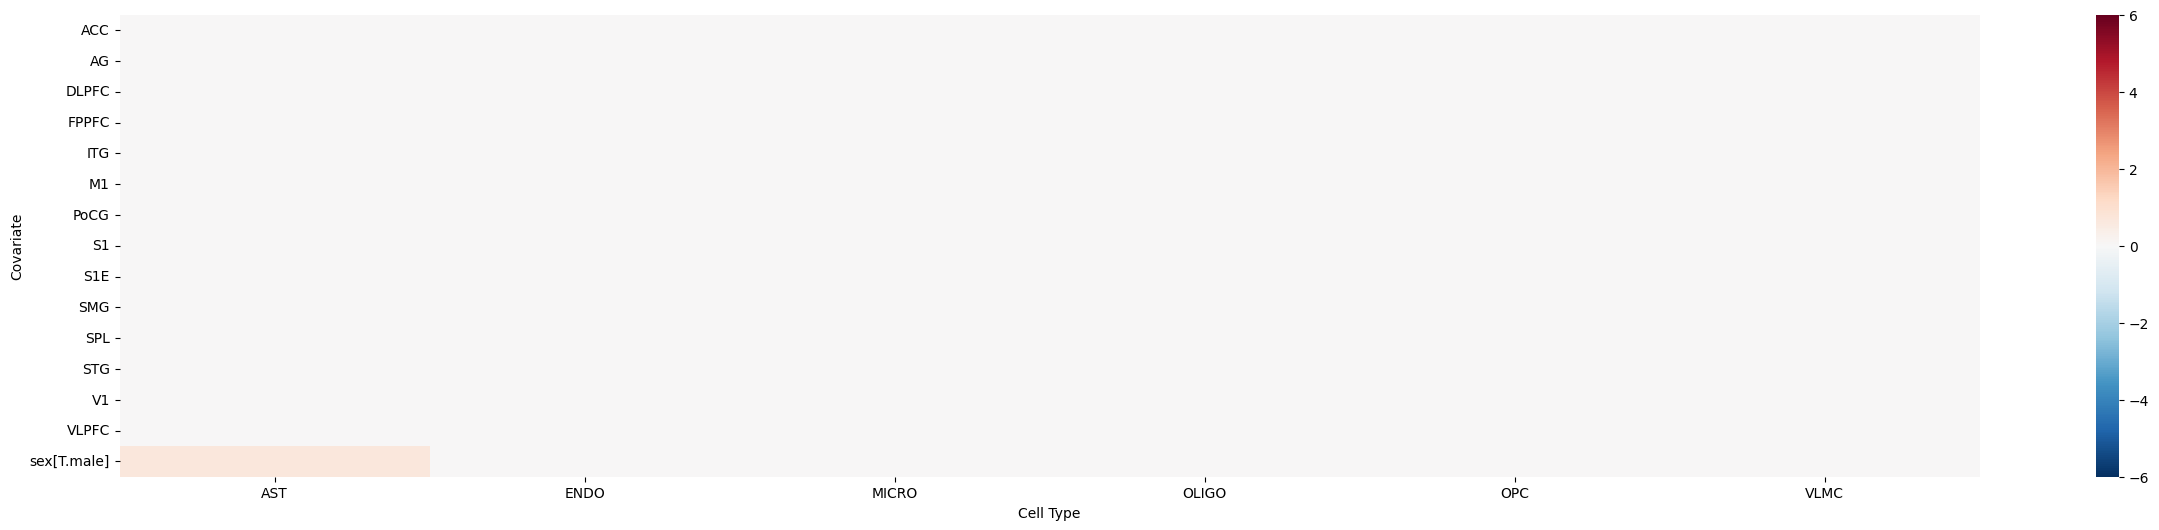

cluster


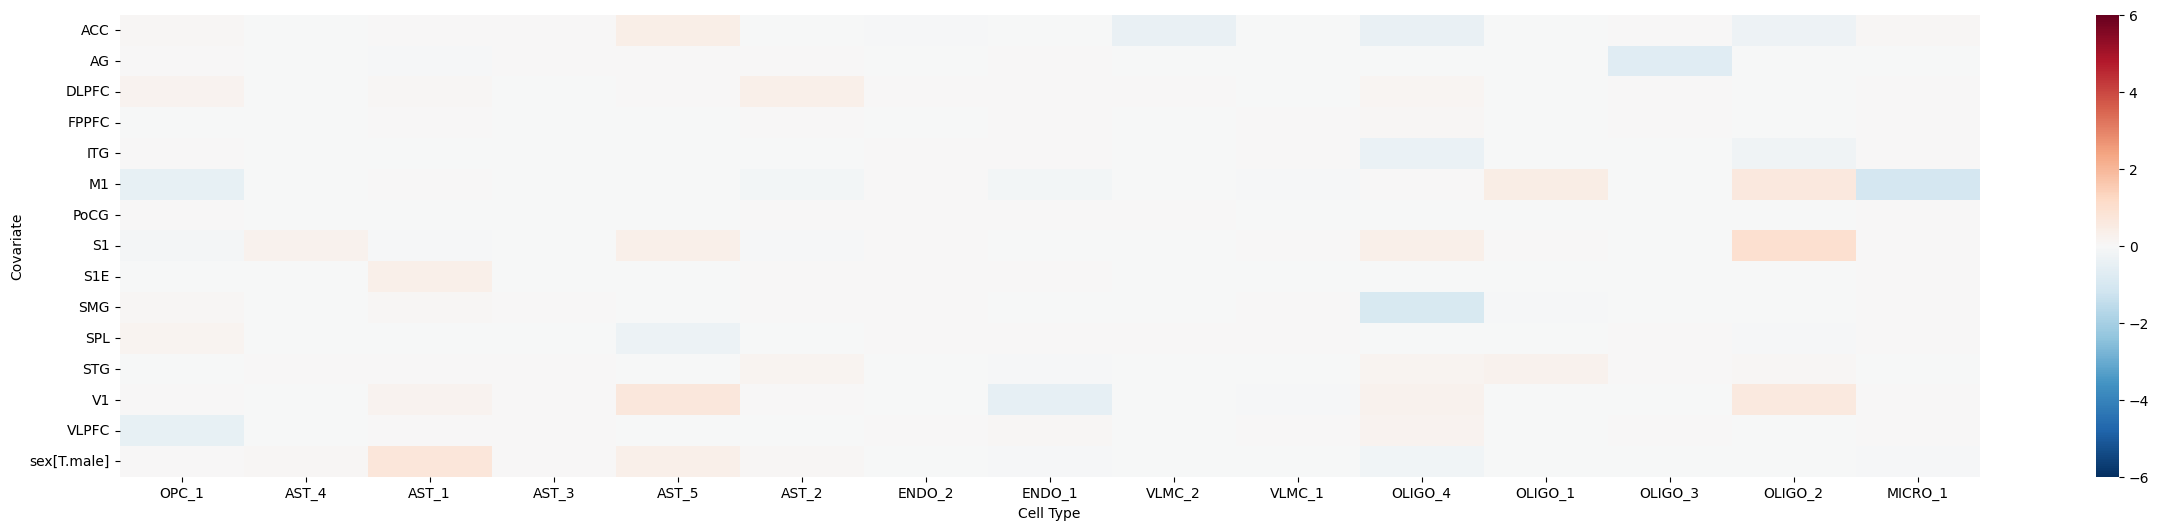

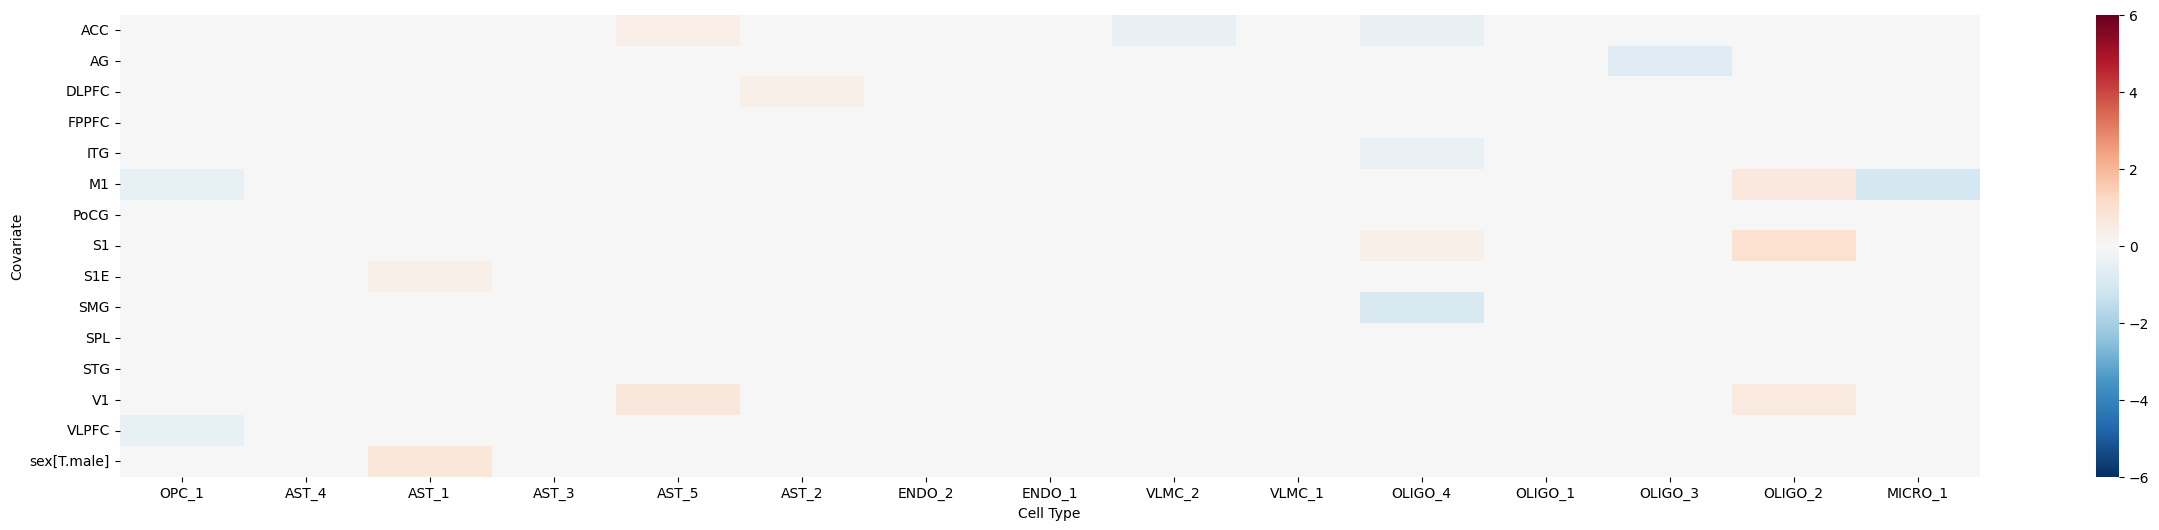

In [6]:
plt.rcParams['figure.figsize'] = (30,6)
plot_size = {"subclass": [-6, 6], "cluster": [-6, 6]}
dend_order = pd.read_csv("dendOrderNonNeuron.csv", header=None)
plot_order = {"cluster": dend_order.iloc[:, 0].to_list()}

plot_colors = {}
covariate_order = ["FPPFC","DLPFC", "VLPFC", "M1", "S1", "S1E", 
"PoCG", "AG","ACC", "SPL", "SMG",  "STG","ITG", "V1", "sex[T.Male]"]
drop_covariates = ["sex[T.Male]"]
labels_keys = ["subclass","cluster"]
j = "region"
k = "cluster"
pwd = "."
if os.path.exists(os.path.join(pwd, "output", "figures")) is False:
            os.makedirs(os.path.join(pwd, "output", "figures"))

for k in labels_keys:
    print(k)
    results_tables = glob.glob(os.path.join("output","cross_areal", j, "**", "non" + k + "_results.csv"))
    results_table = False
    for z in results_tables:
        tmp = pd.read_csv(z, index_col=0)
        tmp["Covariate"] = [re.sub("C\([^,]+, Treatment\('[^\)]+'\)\)\[T.([^\]]+)\]$", "\\1", y) for y in tmp["Covariate"]]
        try:
            results_table = pd.concat([results_table, tmp], axis=0)
        except:
            results_table = tmp.copy()
    
    results_table["Credible"] = results_table["Final Parameter"] != 0
    
    results_table
    try:
        results_table["Cell Type"] = results_table["Cell Type"].astype("category")
        results_table["Cell Type"] = results_table["Cell Type"].cat.reorder_categories(plot_order[k]) 
    except:
        pass
    try:
        results_table["Covariate"] = results_table["Covariate"].astype("category")
        results_table["Covariate"] = results_table["Covariate"].cat.reorder_categories(covariate_order)
    except:
        pass
    try:    
        results_table = results_table.loc[[l not in drop_covariates for l in results_table["Covariate"]], :]
        results_table["Covariate"] = results_table["Covariate"].cat.remove_unused_categories()
    except:
        pass
    tmp = results_table.loc[:, ["Covariate", "Cell Type", "Final Parameter"]].groupby(["Covariate", "Cell Type"]).mean().reset_index()
    tmp.columns = ["Covariate", "Cell Type", "Effect Size"]
    ax = sns.heatmap(
        tmp.pivot(index="Covariate", columns="Cell Type", values="Effect Size"),
        center=0,
        cmap="RdBu_r",
        vmin=plot_size[k][0],
        vmax=plot_size[k][1],
        xticklabels=True
    );
    plt.savefig(os.path.join(pwd, "output", "figures", "non_neuron_" + j + "_" + k + "_effect_size_unfiltered.pdf"), bbox_inches="tight")
    plt.show();
    tmp.to_csv(os.path.join(pwd, "output", "figures", "non_neuron_" + j + "_" + k + "_effect_size_unfiltered.csv"))
    
    tmp2 = results_table.loc[:, ["Covariate", "Cell Type", "Inclusion probability"]].groupby(["Covariate", "Cell Type"]).mean().reset_index()
    tmp.loc[tmp2["Inclusion probability"] < 0.8, "Effect Size"] = 0
    ax = sns.heatmap(
        tmp.pivot(index="Covariate", columns="Cell Type", values="Effect Size"),
        center=0, cmap="RdBu_r",
        vmin=plot_size[k][0],
        vmax=plot_size[k][1],
        xticklabels=True
    );
    plt.savefig(os.path.join(pwd, "output", "figures", "non_neuron_" + j + "_" + k + "_effect_size_p_gt_0.8.pdf"), bbox_inches="tight")
    plt.show();
    tmp.to_csv(os.path.join(pwd, "output", "figures", "non_neuron_" + j + "_" + k + "_effect_size_p_gt_0.8.csv"))